In [1]:
import matplotlib.pyplot as plt
import os

import seaborn as sns
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor

from flox.nn import FloxModule
from flox.flock import Flock
from flox.runtime import federated_fit
from flox.strategies import FedSGD

plt.style.use("ggplot")

In [2]:
class MyModule(FloxModule):
    def __init__(self, lr: float = 0.01):
        super().__init__()
        self.lr = lr
        self.flatten = nn.Flatten()
        self.linear_stack = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        return self.linear_stack(x)

    def training_step(self, batch, batch_idx):
        inputs, targets = batch
        preds = self(inputs)
        loss = nn.functional.cross_entropy(preds, targets)
        return loss

    def configure_optimizers(self):
        return optim.SGD(self.parameters(), lr=self.lr)

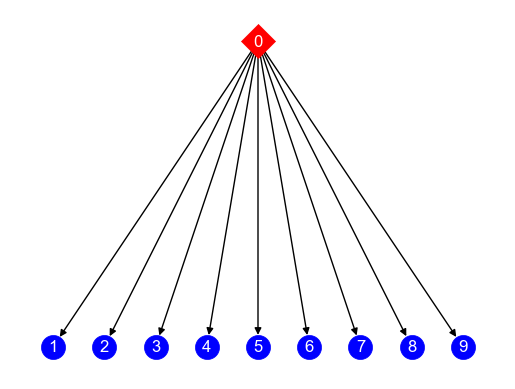

In [3]:
flock = Flock.from_yaml("examples/flocks/2-tier.yaml")
flock.draw()
plt.show()

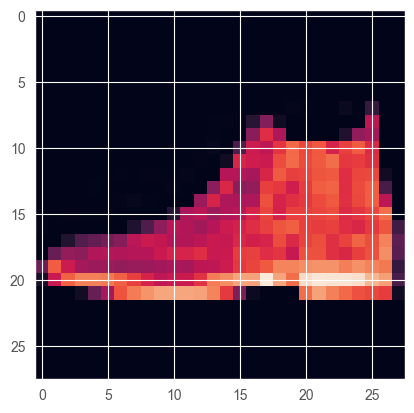

In [4]:
fmnist = FashionMNIST(
    root=os.environ["TORCH_DATASETS"],
    download=False,
    train=False,
    transform=ToTensor()
)
sample, _ = next(iter(fmnist))
plt.imshow(sample.squeeze().numpy())
plt.show()

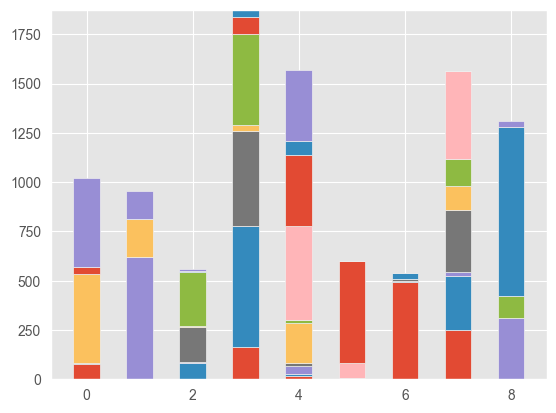

In [5]:
from flox.data import federated_split, fed_barplot

fed_subsets = federated_split(fmnist, flock, num_classes=10, samples_alpha=1.0, labels_alpha=0.1)
fed_barplot(fed_subsets, num_labels=10)
plt.show()

# Synchronous Federated Learning 

In [6]:
_, sync_history = federated_fit(
    flock,
    MyModule(),
    fed_subsets,
    num_global_rounds=5,
    strategy=FedSGD(),
    kind="sync",
    launcher="thread",
)
sync_history.head()

federated_fit::sync: 100%|██████████| 5/5 [00:08<00:00,  1.67s/it]


,train/loss,train/epoch,train/batch_idx,train/time,node/idx,node/kind,parent/idx,parent/kind,round,train/rel_time
0,2.295307,0,0,2024-01-25 13:47:46.292159,1,worker,0,leader,0,0.075563
1,2.225168,0,1,2024-01-25 13:47:46.301381,1,worker,0,leader,0,0.084785
2,2.155839,0,2,2024-01-25 13:47:46.309920,1,worker,0,leader,0,0.093324
3,2.088209,0,3,2024-01-25 13:47:46.317990,1,worker,0,leader,0,0.101394
4,2.065624,0,4,2024-01-25 13:47:46.327071,1,worker,0,leader,0,0.110475


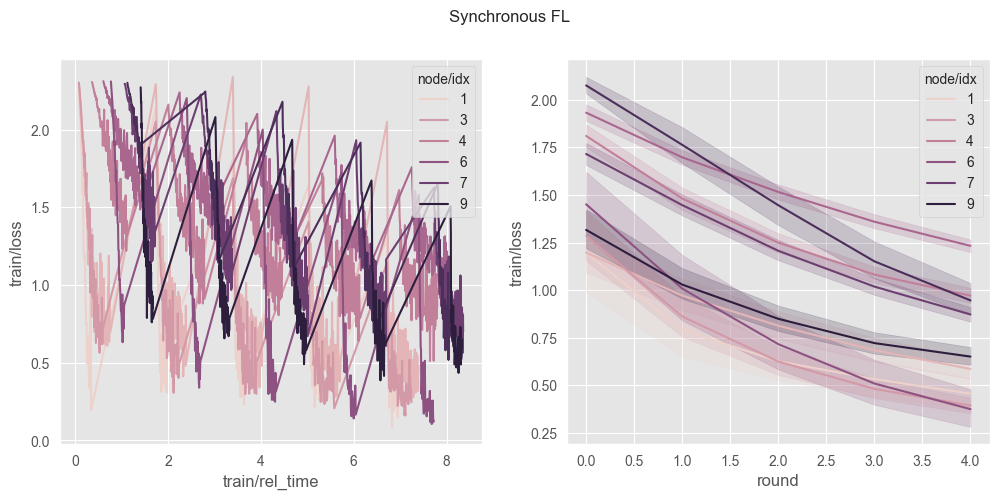

In [7]:
sync_hist = sync_history.copy()
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
sns.lineplot(sync_hist, x="train/rel_time", y="train/loss", hue="node/idx", ax=axes[0])
sns.lineplot(sync_hist, x="round", y="train/loss", hue="node/idx", ax=axes[1])
fig.suptitle("Synchronous FL")
plt.show()

# Asynchronous Federated Learning

In [8]:
_, async_history = federated_fit(
    flock,
    MyModule(),
    fed_subsets,
    num_global_rounds=5,
    strategy=FedSGD(),
    kind="async",  # How to specify AsyncFL
    launcher="thread",
)
async_history.head()

100%|██████████| 45/45 [00:11<00:00,  3.92it/s]


,train/loss,train/epoch,train/batch_idx,train/time,node/idx,node/kind,parent/idx,parent/kind,round,train/rel_time
0,2.275336,0,0,2024-01-25 13:47:55.354584,1,worker,0,leader,0,0.016232
1,2.210263,0,1,2024-01-25 13:47:55.362028,1,worker,0,leader,0,0.023676
2,2.139915,0,2,2024-01-25 13:47:55.373638,1,worker,0,leader,0,0.035286
3,2.088556,0,3,2024-01-25 13:47:55.385212,1,worker,0,leader,0,0.046860
4,2.043423,0,4,2024-01-25 13:47:55.395321,1,worker,0,leader,0,0.056969


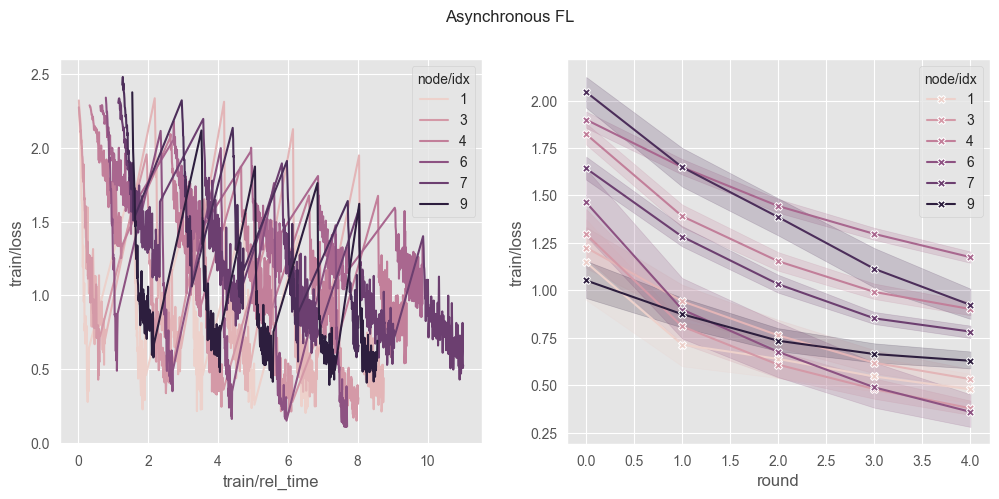

In [9]:
async_hist = async_history.copy()
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
sns.lineplot(async_hist, x="train/rel_time", y="train/loss", hue="node/idx", ax=axes[0])
sns.lineplot(async_hist, x="round", y="train/loss", hue="node/idx", ax=axes[1], marker="X")
fig.suptitle("Asynchronous FL")
plt.show()

# Comparison: Asynchronous vs. Synchronous Federated Learning

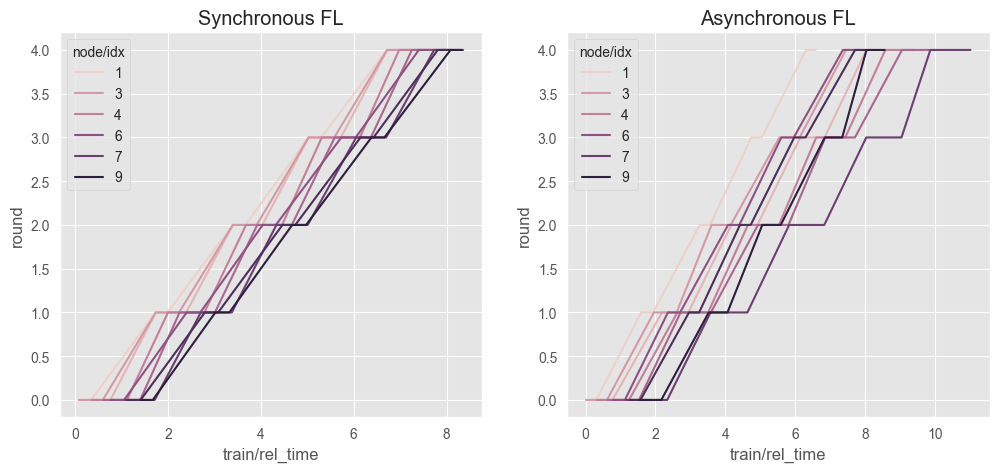

In [10]:
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
sns.lineplot(sync_hist, x="train/rel_time", y="round", hue="node/idx", ax=axes[0])
sns.lineplot(async_hist, x="train/rel_time", y="round", hue="node/idx", ax=axes[1])
axes[0].set_title("Synchronous FL")
axes[1].set_title("Asynchronous FL")
plt.show()

## TO-DO
Look into plotting the idle time for the async vs. sync case.